<a href="https://colab.research.google.com/github/arife-16/ASD-project/blob/main/01_nested_cv_baselines.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Nested CV Baselines — ComBat + Confounds

Runs Logistic Regression (and SVM variants) with **fold-safe ComBat** and **confound regression** across **AAL116/CC200/CC400**.

In [3]:
PROJECT_ROOT = '/content/drive/MyDrive/ASD-project'

%cd $PROJECT_ROOT
%pip -q install -U --force-reinstall -r requirements.txt

/content/drive/MyDrive/ASD-project
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.0/62.0 kB 1.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.8/60.8 kB 3.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.6/57.6 kB 4.0 MB/s eta 0:00:00
ERROR: Ignored the following versions that require a different python version: 1.10.0 Requires-Python <3.12,>=3.8; 1.10.0rc1 Requires-Python <3.12,>=3.8; 1.10.0rc2 Requires-Python <3.12,>=3.8; 1.10.1 Requires-Python <3.12,>=3.8; 1.21.2 Requires-Python >=3.7,<3.11; 1.21.3 Requires-Python >=3.7,<3.11; 1.21.4 Requires-Python >=3.7,<3.11; 1.21.5 Requires-Python >=3.7,<3.11; 1.21.6 Requires-Python >=3.7,<3.11; 1.6.2 Requires-Python >=3.7,<3.10; 1.6.3 Requires-Python >=3.7,<3.10; 1.7.0 Requires-Python >=3.7,<3.10; 1.7.1 Requires-Python >=3.7,<3.10; 1.7.2 Requires-Python >=3.7,<3.11; 1.7.3 Requires-Python >=3.7,<3.11; 1.8.0 Requires-Python >=3.8,<3.11; 1.8.0rc1 Requires-Python >=3.8,<3.11; 1.8.0rc2 Requires-Python >=3.8,<3

In [4]:

import os, json, numpy as np, pandas as pd
from tqdm import tqdm
from sklearn.metrics import roc_auc_score, average_precision_score
from sklearn.model_selection import StratifiedGroupKFold

from src.utils import set_global_seed, ensure_dir
from src.data import DataPaths, load_metadata, link_fc_paths, load_upper_triangle_from_npy
from src.harmonize import combat_fit, combat_apply
from src.confounds import ConfoundRegressor
from src.models_ml import MLConfig, build_pipeline
from src.metrics import compute_metrics, bootstrap_ci

set_global_seed(1337)

In [5]:
import os
import numpy as np, pandas as pd

PHENOTYPE_CSV = '/content/drive/MyDrive/ASD-project/data/ABIDE_Project/Phenotypic_V1_0b_preprocessed1 (2).csv'
FC_BASE_DIR   = '/content/drive/MyDrive/ASD-project/data/ABIDE_Project/preprocessed_dataset'

atlas_to_subdir = {
    "AAL116": "fc_matrices_aal",
    "CC200":  "rois_cc200_cpac_filt_noglobal/Outputs/cpac/filt_noglobal/rois_cc200",
    "CC400":  "rois_cc400_cpac_filt_noglobal/Outputs/cpac/filt_noglobal/rois_cc400",
}

# the helpers
def _upper_triangle(mat: np.ndarray) -> np.ndarray:
    mat = 0.5 * (mat + mat.T)
    np.fill_diagonal(mat, 0.0)
    iu = np.triu_indices_from(mat, k=1)
    return mat[iu]

def _fisher_z(r: np.ndarray) -> np.ndarray:
    r = np.clip(r, -0.999999, 0.999999)
    return 0.5 * np.log((1.0 + r) / (1.0 - r))

def _corr_from_timeseries(ts: np.ndarray) -> np.ndarray:
    """
    Robust Pearson correlation from time-series with potential zero-variance ROIs.
    ts: shape (T, R)
    """
    if ts.ndim == 1:
        ts = ts[:, None]
    # Standardize with protection against zero std
    mean = ts.mean(axis=0, keepdims=True)
    std  = ts.std(axis=0, ddof=1, keepdims=True)
    safe_std = np.where(std == 0, 1.0, std)
    z = (ts - mean) / safe_std  # columns (ROIs) standardized; zero-variance columns become zeros
    # sample correlation via normalized covariance
    T = z.shape[0]
    corr = (z.T @ z) / max(T - 1, 1)
    # zero rows/cols that correspond to zero-variance ROIs (std==0)
    bad = (std.flatten() == 0)
    if bad.any():
        corr[:, bad] = 0.0
        corr[bad, :] = 0.0
    np.fill_diagonal(corr, 1.0)
    return corr

def _load_fc_vector_from_file(path: str, atlas_key: str) -> np.ndarray:
    """AAL116: path -> .npy connectivity matrix
       CC200/CC400: path -> .1D ROI time series; compute Pearson FC + Fisher z"""
    if atlas_key == "AAL116":
        mat = np.load(path)
        return _upper_triangle(mat)

    ts = np.loadtxt(path)
    corr = _corr_from_timeseries(ts)
    corr_z = _fisher_z(corr)
    return _upper_triangle(corr_z)

def _normalize_pheno_columns(df: pd.DataFrame) -> pd.DataFrame:

    df = df.rename(columns={c: c.upper() for c in df.columns})

    if "MEAN_FD" not in df.columns:
        for cand in ["FUNC_MEAN_FD", "FUNC_MEANFD", "MEANFD"]:
            if cand in df.columns:
                df["MEAN_FD"] = pd.to_numeric(df[cand], errors="coerce")
                break
        if "MEAN_FD" not in df.columns:
            df["MEAN_FD"] = np.nan
    # DX_GROUP to LABEL
    if "DX_GROUP" in df.columns:
        df["DX_GROUP"] = df["DX_GROUP"].astype(str).str.strip()
        df["LABEL"] = df["DX_GROUP"].map({"1": "ASD", "2": "TD", "ASD": "ASD", "TD": "TD"})
    else:
        raise KeyError("DX_GROUP column not found in phenotype CSV.")
    # SEX_NUM
    if "SEX" in df.columns:
        df["SEX"] = df["SEX"].astype(str).str.upper().str.strip()
        df["SEX_NUM"] = df["SEX"].map({"M": 1, "F": 0, "1": 1, "2": 0}).fillna(0).astype(int)
    else:
        df["SEX_NUM"] = 0

    if "FILE_ID" not in df.columns:
        raise KeyError("FILE_ID column not found in phenotype CSV.")
    df["FILE_ID"] = df["FILE_ID"].astype(str).str.strip()

    if "SITE_ID" not in df.columns:
        raise KeyError("SITE_ID column not found in phenotype CSV.")
    return df

# main loader
def prepare_dataset(atlas: str):
    df = pd.read_csv(PHENOTYPE_CSV)
    df = _normalize_pheno_columns(df)

    subdir = atlas_to_subdir[atlas]
    base_dir = os.path.join(FC_BASE_DIR, subdir)

    # Build file names from FILE_ID
    if atlas == "AAL116":
        df["FC_PATH"] = df["FILE_ID"].apply(lambda fid: os.path.join(base_dir, f"{fid}.npy"))
    elif atlas == "CC200":
        df["FC_PATH"] = df["FILE_ID"].apply(lambda fid: os.path.join(base_dir, f"{fid}_rois_cc200.1D"))
    elif atlas == "CC400":
        df["FC_PATH"] = df["FILE_ID"].apply(lambda fid: os.path.join(base_dir, f"{fid}_rois_cc400.1D"))
    else:
        raise ValueError("Unknown atlas key")

    exists = df["FC_PATH"].map(os.path.exists)
    missing = (~exists).sum()
    if missing > 0:
        print(f"[{atlas}] Warning: {missing} subjects missing files under {base_dir}. Showing 5 examples:")
        print(df.loc[~exists, ["FILE_ID", "FC_PATH"]].head())

    df = df.loc[exists].reset_index(drop=True)
    if len(df) == 0:
        raise FileNotFoundError(f"No files found for {atlas} in {base_dir}. Check paths & naming.")

    # Build upper-triangle vectors, labels, groups, confounds
    X = np.vstack([_load_fc_vector_from_file(p, atlas) for p in df["FC_PATH"]])
    y = (df["LABEL"].values == "ASD").astype(int)
    groups = df["SITE_ID"].astype(str).values

    conf_df = df[["AGE_AT_SCAN", "SEX_NUM", "MEAN_FD"]].apply(pd.to_numeric, errors="coerce")
    conf_df = conf_df.fillna(conf_df.median(numeric_only=True))
    confounds = conf_df.values

    return X, y, groups, confounds, df

# smoke test
for atlas in ["AAL116","CC200","CC400"]:
    try:
        X, y, g, C, meta = prepare_dataset(atlas)
        print(atlas, "X:", X.shape, "labels:", np.bincount(y))
        print("  sample path:", meta["FC_PATH"].iloc[0])
    except Exception as e:
        print(atlas, "skipped:", repr(e))

[AAL116] Warning: 228 subjects missing files under /content/drive/MyDrive/ASD-project/data/ABIDE_Project/preprocessed_dataset/fc_matrices_aal. Showing 5 examples:
         FILE_ID                                            FC_PATH
0    no_filename  /content/drive/MyDrive/ASD-project/data/ABIDE_...
1   Pitt_0050003  /content/drive/MyDrive/ASD-project/data/ABIDE_...
11  Pitt_0050013  /content/drive/MyDrive/ASD-project/data/ABIDE_...
15  Pitt_0050017  /content/drive/MyDrive/ASD-project/data/ABIDE_...
16  Pitt_0050019  /content/drive/MyDrive/ASD-project/data/ABIDE_...
AAL116 X: (884, 6670) labels: [476 408]
  sample path: /content/drive/MyDrive/ASD-project/data/ABIDE_Project/preprocessed_dataset/fc_matrices_aal/Pitt_0050004.npy
[CC200] Warning: 228 subjects missing files under /content/drive/MyDrive/ASD-project/data/ABIDE_Project/preprocessed_dataset/rois_cc200_cpac_filt_noglobal/Outputs/cpac/filt_noglobal/rois_cc200. Showing 5 examples:
         FILE_ID                                    

In [6]:
import pandas as pd
from src.harmonize import combat_fit, combat_apply
from src.confounds import ConfoundRegressor

def fold_safe_transform(X_tr, X_te, groups_tr, groups_te, conf_tr, conf_te, use_combat=True):
    # 1) Optional ComBat
    if use_combat:
        try:
            model = combat_fit(X_tr, pd.Series(groups_tr), pd.DataFrame(conf_tr))
            Xtr_h = combat_apply(model, X_tr, pd.Series(groups_tr), pd.DataFrame(conf_tr))
            Xte_h = combat_apply(model, X_te, pd.Series(groups_te), pd.DataFrame(conf_te))
        except Exception as e:
            print(f"[ComBat disabled this fold] {e}")
            Xtr_h, Xte_h = X_tr, X_te
    else:
        Xtr_h, Xte_h = X_tr, X_te

    # 2) Confound regression
    reg = ConfoundRegressor().fit(Xtr_h, conf_tr)
    Xtr_r = reg.transform(Xtr_h, conf_tr)
    Xte_r = reg.transform(Xte_h, conf_te)
    return Xtr_r, Xte_r

In [7]:
import numpy as np, os, json
from sklearn.metrics import roc_auc_score, average_precision_score
from sklearn.model_selection import StratifiedGroupKFold
from src.models_ml import MLConfig, build_pipeline
from src.metrics import compute_metrics, bootstrap_ci
from src.utils import ensure_dir

def run_nested_cv(atlas: str, model_name='lr', C_list=(0.0001, 0.001, 0.1, 0.3, 1.0, 3.0, 10.0), seed_outer=1337, seed_inner=2027):
    X, y, groups, confounds, meta = prepare_dataset(atlas)
    outer = StratifiedGroupKFold(n_splits=5, shuffle=True, random_state=seed_outer)
    fold_results, y_all, p_all = [], [], []

    for fold, (tr_idx, te_idx) in enumerate(outer.split(X, y, groups=groups), 1):
        X_tr, X_te = X[tr_idx], X[te_idx]
        y_tr, y_te = y[tr_idx], y[te_idx]
        g_tr, g_te = groups[tr_idx], groups[te_idx]
        c_tr, c_te = confounds[tr_idx], confounds[te_idx]

        # inner CV: pick C
        inner = StratifiedGroupKFold(n_splits=3, shuffle=True, random_state=seed_inner)
        best_auc, best_C = -np.inf, None
        for C in C_list:
            aucs = []
            for itr, ival in inner.split(X_tr, y_tr, groups=g_tr):
                Xtr_i, Xval_i = X_tr[itr], X_tr[ival]
                ytr_i, yval_i = y_tr[itr], y_tr[ival]
                gtr_i, gval_i = g_tr[itr], g_tr[ival]
                ctr_i, cval_i = c_tr[itr], c_tr[ival]

                Xtr_t, Xval_t = fold_safe_transform(Xtr_i, Xval_i, gtr_i, gval_i, ctr_i, cval_i, use_combat=False)
                pipe = build_pipeline(MLConfig(model=model_name, C=C))
                pipe.fit(Xtr_t, ytr_i)
                prob = pipe.predict_proba(Xval_t)[:,1]
                aucs.append(roc_auc_score(yval_i, prob))
            mean_auc = float(np.mean(aucs))
            if mean_auc > best_auc:
                best_auc, best_C = mean_auc, C

        # retrain on full train with best C → test
        Xtr_t, Xte_t = fold_safe_transform(X_tr, X_te, g_tr, g_te, c_tr, c_te, use_combat=False)
        pipe = build_pipeline(MLConfig(model=model_name, C=best_C))
        pipe.fit(Xtr_t, y_tr)
        prob_te = pipe.predict_proba(Xte_t)[:,1]
        pred_te = (prob_te >= 0.5).astype(int)

        m = compute_metrics(y_te, prob_te, pred_te)
        m.update({"best_C": best_C, "fold": fold})
        fold_results.append(m)

        y_all.append(y_te); p_all.append(prob_te)
        print(f"[{atlas}] Fold {fold}: AUC={m['roc_auc']:.3f}, PR-AUC={m['pr_auc']:.3f}, Acc={m['accuracy']:.3f}, F1={m['f1']:.3f} (C={best_C})")

    y_all = np.concatenate(y_all); p_all = np.concatenate(p_all)
    auc_ci = bootstrap_ci(y_all, p_all, lambda yt, yp: roc_auc_score(yt, yp))
    pr_ci  = bootstrap_ci(y_all, p_all, lambda yt, yp: average_precision_score(yt, yp))

    summary = {
        "atlas": atlas,
        "model": model_name,
        "folds": fold_results,
        "mean": {k: float(np.mean([fr[k] for fr in fold_results])) for k in ["roc_auc","pr_auc","accuracy","f1"]},
        "std":  {k: float(np.std([fr[k] for fr in fold_results]))  for k in ["roc_auc","pr_auc","accuracy","f1"]},
        "bootstrap_ci": {"roc_auc": auc_ci, "pr_auc": pr_ci},
        "n_subjects": int(len(y))
    }
    return summary

# Run across atlases and save
results = {}
for atlas in ["AAL116","CC200","CC400"]:
    try:
        results[atlas] = run_nested_cv(atlas, model_name='lr')
    except Exception as e:
        print(f"{atlas} failed:", e)

ensure_dir(os.path.join(PROJECT_ROOT, "outputs"))
out_path = os.path.join(PROJECT_ROOT, "outputs", "baseline_nestedcv_combat_confounds_lr.json")
with open(out_path, "w") as f:
    json.dump(results, f, indent=2)
print("Saved ->", out_path)

[AAL116] Warning: 228 subjects missing files under /content/drive/MyDrive/ASD-project/data/ABIDE_Project/preprocessed_dataset/fc_matrices_aal. Showing 5 examples:
         FILE_ID                                            FC_PATH
0    no_filename  /content/drive/MyDrive/ASD-project/data/ABIDE_...
1   Pitt_0050003  /content/drive/MyDrive/ASD-project/data/ABIDE_...
11  Pitt_0050013  /content/drive/MyDrive/ASD-project/data/ABIDE_...
15  Pitt_0050017  /content/drive/MyDrive/ASD-project/data/ABIDE_...
16  Pitt_0050019  /content/drive/MyDrive/ASD-project/data/ABIDE_...
[AAL116] Fold 1: AUC=0.738, PR-AUC=0.782, Acc=0.600, F1=0.593 (C=0.001)
[AAL116] Fold 2: AUC=0.734, PR-AUC=0.672, Acc=0.676, F1=0.602 (C=0.001)
[AAL116] Fold 3: AUC=0.699, PR-AUC=0.747, Acc=0.652, F1=0.692 (C=0.1)
[AAL116] Fold 4: AUC=0.670, PR-AUC=0.600, Acc=0.609, F1=0.569 (C=0.0001)
[AAL116] Fold 5: AUC=0.719, PR-AUC=0.642, Acc=0.683, F1=0.662 (C=0.1)
[CC200] Warning: 228 subjects missing files under /content/drive/MyDrive

In [8]:
from collections import defaultdict
from sklearn.model_selection import StratifiedGroupKFold

def run_loso(atlas: str, model_name='lr', C_list=(0.1, 0.3, 1.0, 3.0, 10.0), seed_inner=2027):
    X, y, groups, confounds, meta = prepare_dataset(atlas)
    sites = np.unique(groups)
    site_metrics = []
    y_all, p_all = [], []

    for held_site in sites:
        te_idx = np.where(groups == held_site)[0]
        tr_idx = np.where(groups != held_site)[0]
        if len(te_idx) < 5 or len(tr_idx) < 20:
            continue

        X_tr, X_te = X[tr_idx], X[te_idx]
        y_tr, y_te = y[tr_idx], y[te_idx]
        g_tr, g_te = groups[tr_idx], groups[te_idx]
        c_tr, c_te = confounds[tr_idx], confounds[te_idx]

        # inner CV on training sites only
        inner = StratifiedGroupKFold(n_splits=3, shuffle=True, random_state=seed_inner)
        best_auc, best_C = -np.inf, None
        for C in C_list:
            aucs = []
            for itr, ival in inner.split(X_tr, y_tr, groups=g_tr):
                Xtr_i, Xval_i = X_tr[itr], X_tr[ival]
                ytr_i, yval_i = y_tr[itr], y_tr[ival]
                gtr_i, gval_i = g_tr[itr], g_tr[ival]
                ctr_i, cval_i = c_tr[itr], c_tr[ival]
                Xtr_t, Xval_t = fold_safe_transform(Xtr_i, Xval_i, gtr_i, gval_i, ctr_i, cval_i, use_combat=False)
                pipe = build_pipeline(MLConfig(model=model_name, C=C))
                pipe.fit(Xtr_t, ytr_i)
                prob = pipe.predict_proba(Xval_t)[:,1]
                aucs.append(roc_auc_score(yval_i, prob))
            mean_auc = float(np.mean(aucs))
            if mean_auc > best_auc:
                best_auc, best_C = mean_auc, C

        Xtr_t, Xte_t = fold_safe_transform(X_tr, X_te, g_tr, g_te, c_tr, c_te, use_combat=False)
        pipe = build_pipeline(MLConfig(model=model_name, C=best_C))
        pipe.fit(Xtr_t, y_tr)
        prob_te = pipe.predict_proba(Xte_t)[:,1]
        pred_te = (prob_te >= 0.5).astype(int)
        m = compute_metrics(y_te, prob_te, pred_te)
        m.update({"held_out_site": str(held_site), "n_test": int(len(te_idx)), "best_C": best_C})
        site_metrics.append(m)

        y_all.append(y_te); p_all.append(prob_te)
        print(f"[LOSO {atlas}] Site={held_site:>10s} n={len(te_idx)}  AUC={m['roc_auc']:.3f}  PR-AUC={m['pr_auc']:.3f}")

    if len(site_metrics) == 0:
        raise RuntimeError("LOSO produced no evaluable sites.")

    y_all = np.concatenate(y_all); p_all = np.concatenate(p_all)
    auc_ci = bootstrap_ci(y_all, p_all, lambda yt, yp: roc_auc_score(yt, yp))
    pr_ci  = bootstrap_ci(y_all, p_all, lambda yt, yp: average_precision_score(yt, yp))

    summary = {
        "atlas": atlas,
        "model": model_name,
        "site_metrics": site_metrics,
        "mean": {k: float(np.mean([m[k] for m in site_metrics])) for k in ["roc_auc","pr_auc","accuracy","f1"]},
        "std":  {k: float(np.std([m[k] for m in site_metrics]))  for k in ["roc_auc","pr_auc","accuracy","f1"]},
        "bootstrap_ci": {"roc_auc": auc_ci, "pr_auc": pr_ci},
        "n_subjects": int(len(y))
    }
    return summary

# Run LOSO and save
loso_results = {}
for atlas in ["AAL116","CC200","CC400"]:
    try:
        loso_results[atlas] = run_loso(atlas, model_name='lr')
    except Exception as e:
        print(f"LOSO {atlas} failed:", e)

loso_out = os.path.join(PROJECT_ROOT, "outputs", "loso_combat_confounds_lr.json")
with open(loso_out, "w") as f:
    json.dump(loso_results, f, indent=2)
print("Saved ->", loso_out)

[AAL116] Warning: 228 subjects missing files under /content/drive/MyDrive/ASD-project/data/ABIDE_Project/preprocessed_dataset/fc_matrices_aal. Showing 5 examples:
         FILE_ID                                            FC_PATH
0    no_filename  /content/drive/MyDrive/ASD-project/data/ABIDE_...
1   Pitt_0050003  /content/drive/MyDrive/ASD-project/data/ABIDE_...
11  Pitt_0050013  /content/drive/MyDrive/ASD-project/data/ABIDE_...
15  Pitt_0050017  /content/drive/MyDrive/ASD-project/data/ABIDE_...
16  Pitt_0050019  /content/drive/MyDrive/ASD-project/data/ABIDE_...
[LOSO AAL116] Site=   CALTECH n=37  AUC=0.602  PR-AUC=0.632
[LOSO AAL116] Site=       CMU n=5  AUC=0.000  PR-AUC=0.478
[LOSO AAL116] Site=       KKI n=39  AUC=0.670  PR-AUC=0.500
[LOSO AAL116] Site=  LEUVEN_1 n=29  AUC=0.733  PR-AUC=0.775
[LOSO AAL116] Site=  LEUVEN_2 n=32  AUC=0.713  PR-AUC=0.646
[LOSO AAL116] Site=   MAX_MUN n=42  AUC=0.662  PR-AUC=0.585
[LOSO AAL116] Site=       NYU n=171  AUC=0.729  PR-AUC=0.622
[LOSO AAL

=== Nested CV (no ComBat) ===


,atlas,AUC,AUC_lo,AUC_hi,PR-AUC,PR_lo,PR_hi,Acc,F1,n_subjects
2,CC400,0.740245,0.696878,0.762099,0.706241,0.626490,0.728138,0.691819,0.677305,884
1,CC200,0.738838,0.676641,0.745185,0.712555,0.607334,0.711746,0.680804,0.659697,884
0,AAL116,0.712111,0.664784,0.733563,0.688490,0.598910,0.695512,0.644239,0.623569,884


\n=== LOSO (no ComBat) ===


,atlas,AUC_LOSO,AUC_LOSO_lo,AUC_LOSO_hi,PR-AUC_LOSO,PR_LOSO_lo,PR_LOSO_hi,Acc_LOSO,F1_LOSO
2,CC400,0.725726,0.700013,0.763303,0.711593,0.627938,0.728209,0.648867,0.608934
1,CC200,0.711448,0.688939,0.757251,0.707077,0.640187,0.736912,0.646483,0.621523
0,AAL116,0.680609,0.663582,0.735569,0.685157,0.586134,0.690247,0.642686,0.610684


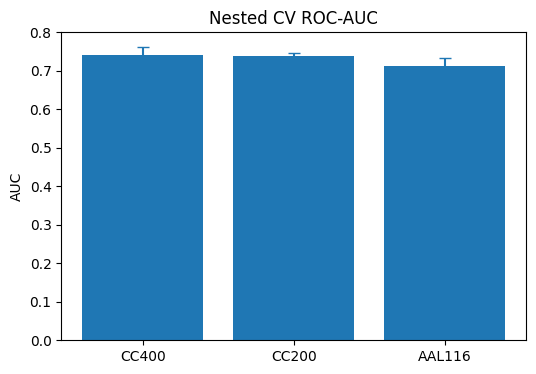

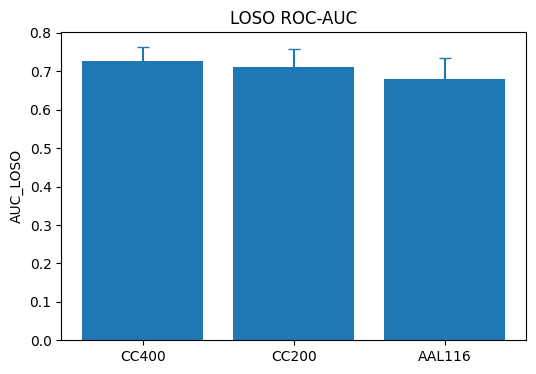

In [11]:
import os, json, numpy as np, pandas as pd
import matplotlib.pyplot as plt

OUT_DIR = os.path.join(PROJECT_ROOT, "outputs")
nested_path = os.path.join(OUT_DIR, "baseline_nestedcv_combat_confounds_lr.json")
loso_path   = os.path.join(OUT_DIR, "loso_combat_confounds_lr.json")

def load_json(p):
    if not os.path.exists(p):
        print("Missing:", p)
        return {}
    with open(p) as f:
        try:
            return json.load(f)
        except Exception:
            return {}

def summarize_nested(obj):
    rows = []
    for atlas, payload in obj.items():
        if not payload: continue
        mean = payload["mean"]; ci = payload.get("bootstrap_ci", {})
        auc_ci = ci.get("roc_auc", [np.nan, np.nan])
        pr_ci  = ci.get("pr_auc",  [np.nan, np.nan])
        rows.append({
            "atlas": atlas,
            "AUC": mean["roc_auc"], "AUC_lo": auc_ci[0], "AUC_hi": auc_ci[1],
            "PR-AUC": mean["pr_auc"], "PR_lo": pr_ci[0], "PR_hi": pr_ci[1],
            "Acc": mean["accuracy"], "F1": mean["f1"],
            "n_subjects": payload.get("n_subjects", np.nan)
        })
    return pd.DataFrame(rows).sort_values("AUC", ascending=False)

def summarize_loso(obj):
    rows = []
    for atlas, payload in obj.items():
        if not payload: continue
        mean = payload["mean"]; ci = payload.get("bootstrap_ci", {})
        auc_ci = ci.get("roc_auc", [np.nan, np.nan])
        pr_ci  = ci.get("pr_auc",  [np.nan, np.nan])
        rows.append({
            "atlas": atlas,
            "AUC_LOSO": mean["roc_auc"], "AUC_LOSO_lo": auc_ci[0], "AUC_LOSO_hi": auc_ci[1],
            "PR-AUC_LOSO": mean["pr_auc"], "PR_LOSO_lo": pr_ci[0], "PR_LOSO_hi": pr_ci[1],
            "Acc_LOSO": mean["accuracy"], "F1_LOSO": mean["f1"]
        })
    return pd.DataFrame(rows).sort_values("AUC_LOSO", ascending=False)

nested = load_json(nested_path)
loso   = load_json(loso_path)

df_nested = summarize_nested(nested)
df_loso   = summarize_loso(loso)

print("=== Nested CV (no ComBat) ===")
display(df_nested)
print("\\n=== LOSO (no ComBat) ===")
display(df_loso)

# bar plots
def bar_with_ci(df, xcol, ycol, lo, hi, title):
    if df.empty:
        print(f"No data for {title}");
        return
    xs = np.arange(len(df))
    plt.figure(figsize=(6,4))
    plt.bar(xs, df[ycol].values)
    # error bars
    yerr = np.vstack([df[ycol].values - df[lo].values, df[hi].values - df[ycol].values])
    plt.errorbar(xs, df[ycol].values, yerr=yerr, fmt='none', capsize=4)
    plt.xticks(xs, df[xcol].values)
    plt.ylabel(ycol); plt.title(title); plt.show()

bar_with_ci(df_nested, "atlas", "AUC", "AUC_lo", "AUC_hi", "Nested CV ROC-AUC")
bar_with_ci(df_loso,   "atlas", "AUC_LOSO", "AUC_LOSO_lo", "AUC_LOSO_hi", "LOSO ROC-AUC")